[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [5]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [7]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [8]:
from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

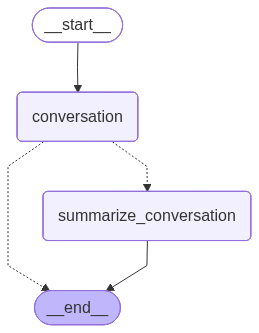

In [9]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [10]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Lance. How can I help you today?
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable game that you particularly enjoyed?


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [11]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [12]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Yes, as of September 2023, Nick Bosa became the highest-paid defensive player in NFL history. He signed a five-year contract extension with the San Francisco 49ers worth $170 million, with $122.5 million guaranteed. Bosa is known for his exceptional skills as a defensive end and has been a key player for the 49ers.


In [13]:
graph.get_state(config).values.get("summary","")

'Lance introduced himself and expressed his support for the San Francisco 49ers, mentioning a particular liking for Nick Bosa. The conversation highlighted that Nick Bosa became the highest-paid defensive player in NFL history as of September 2023, with a five-year, $170 million contract extension with the 49ers.'

## LangSmith

Let's review the trace!

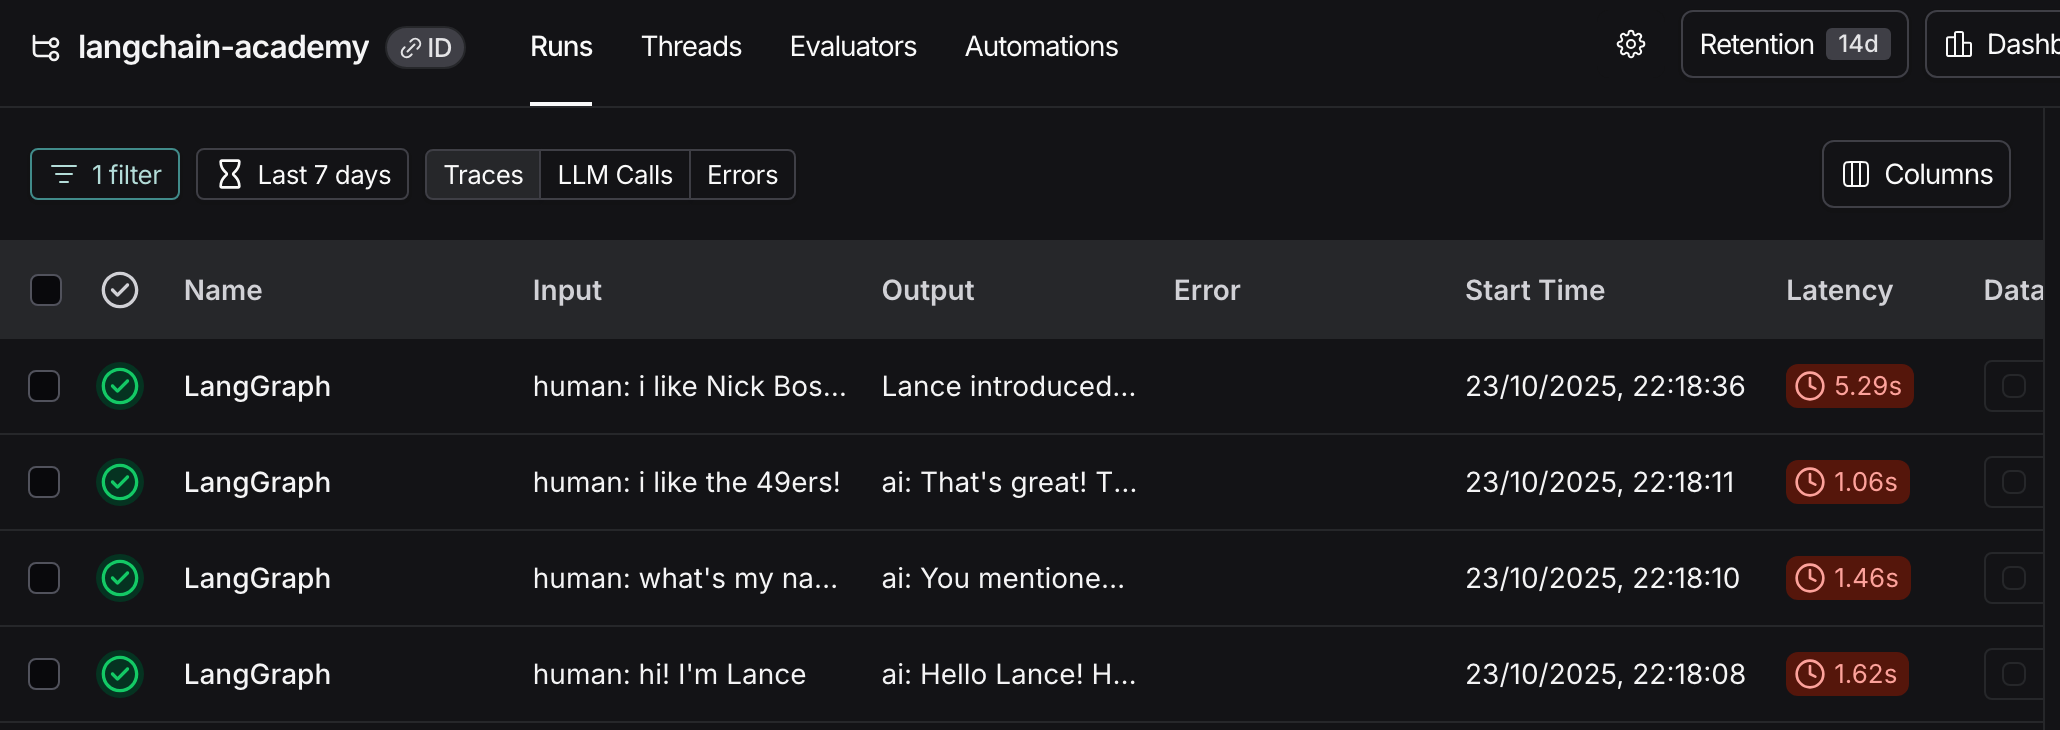
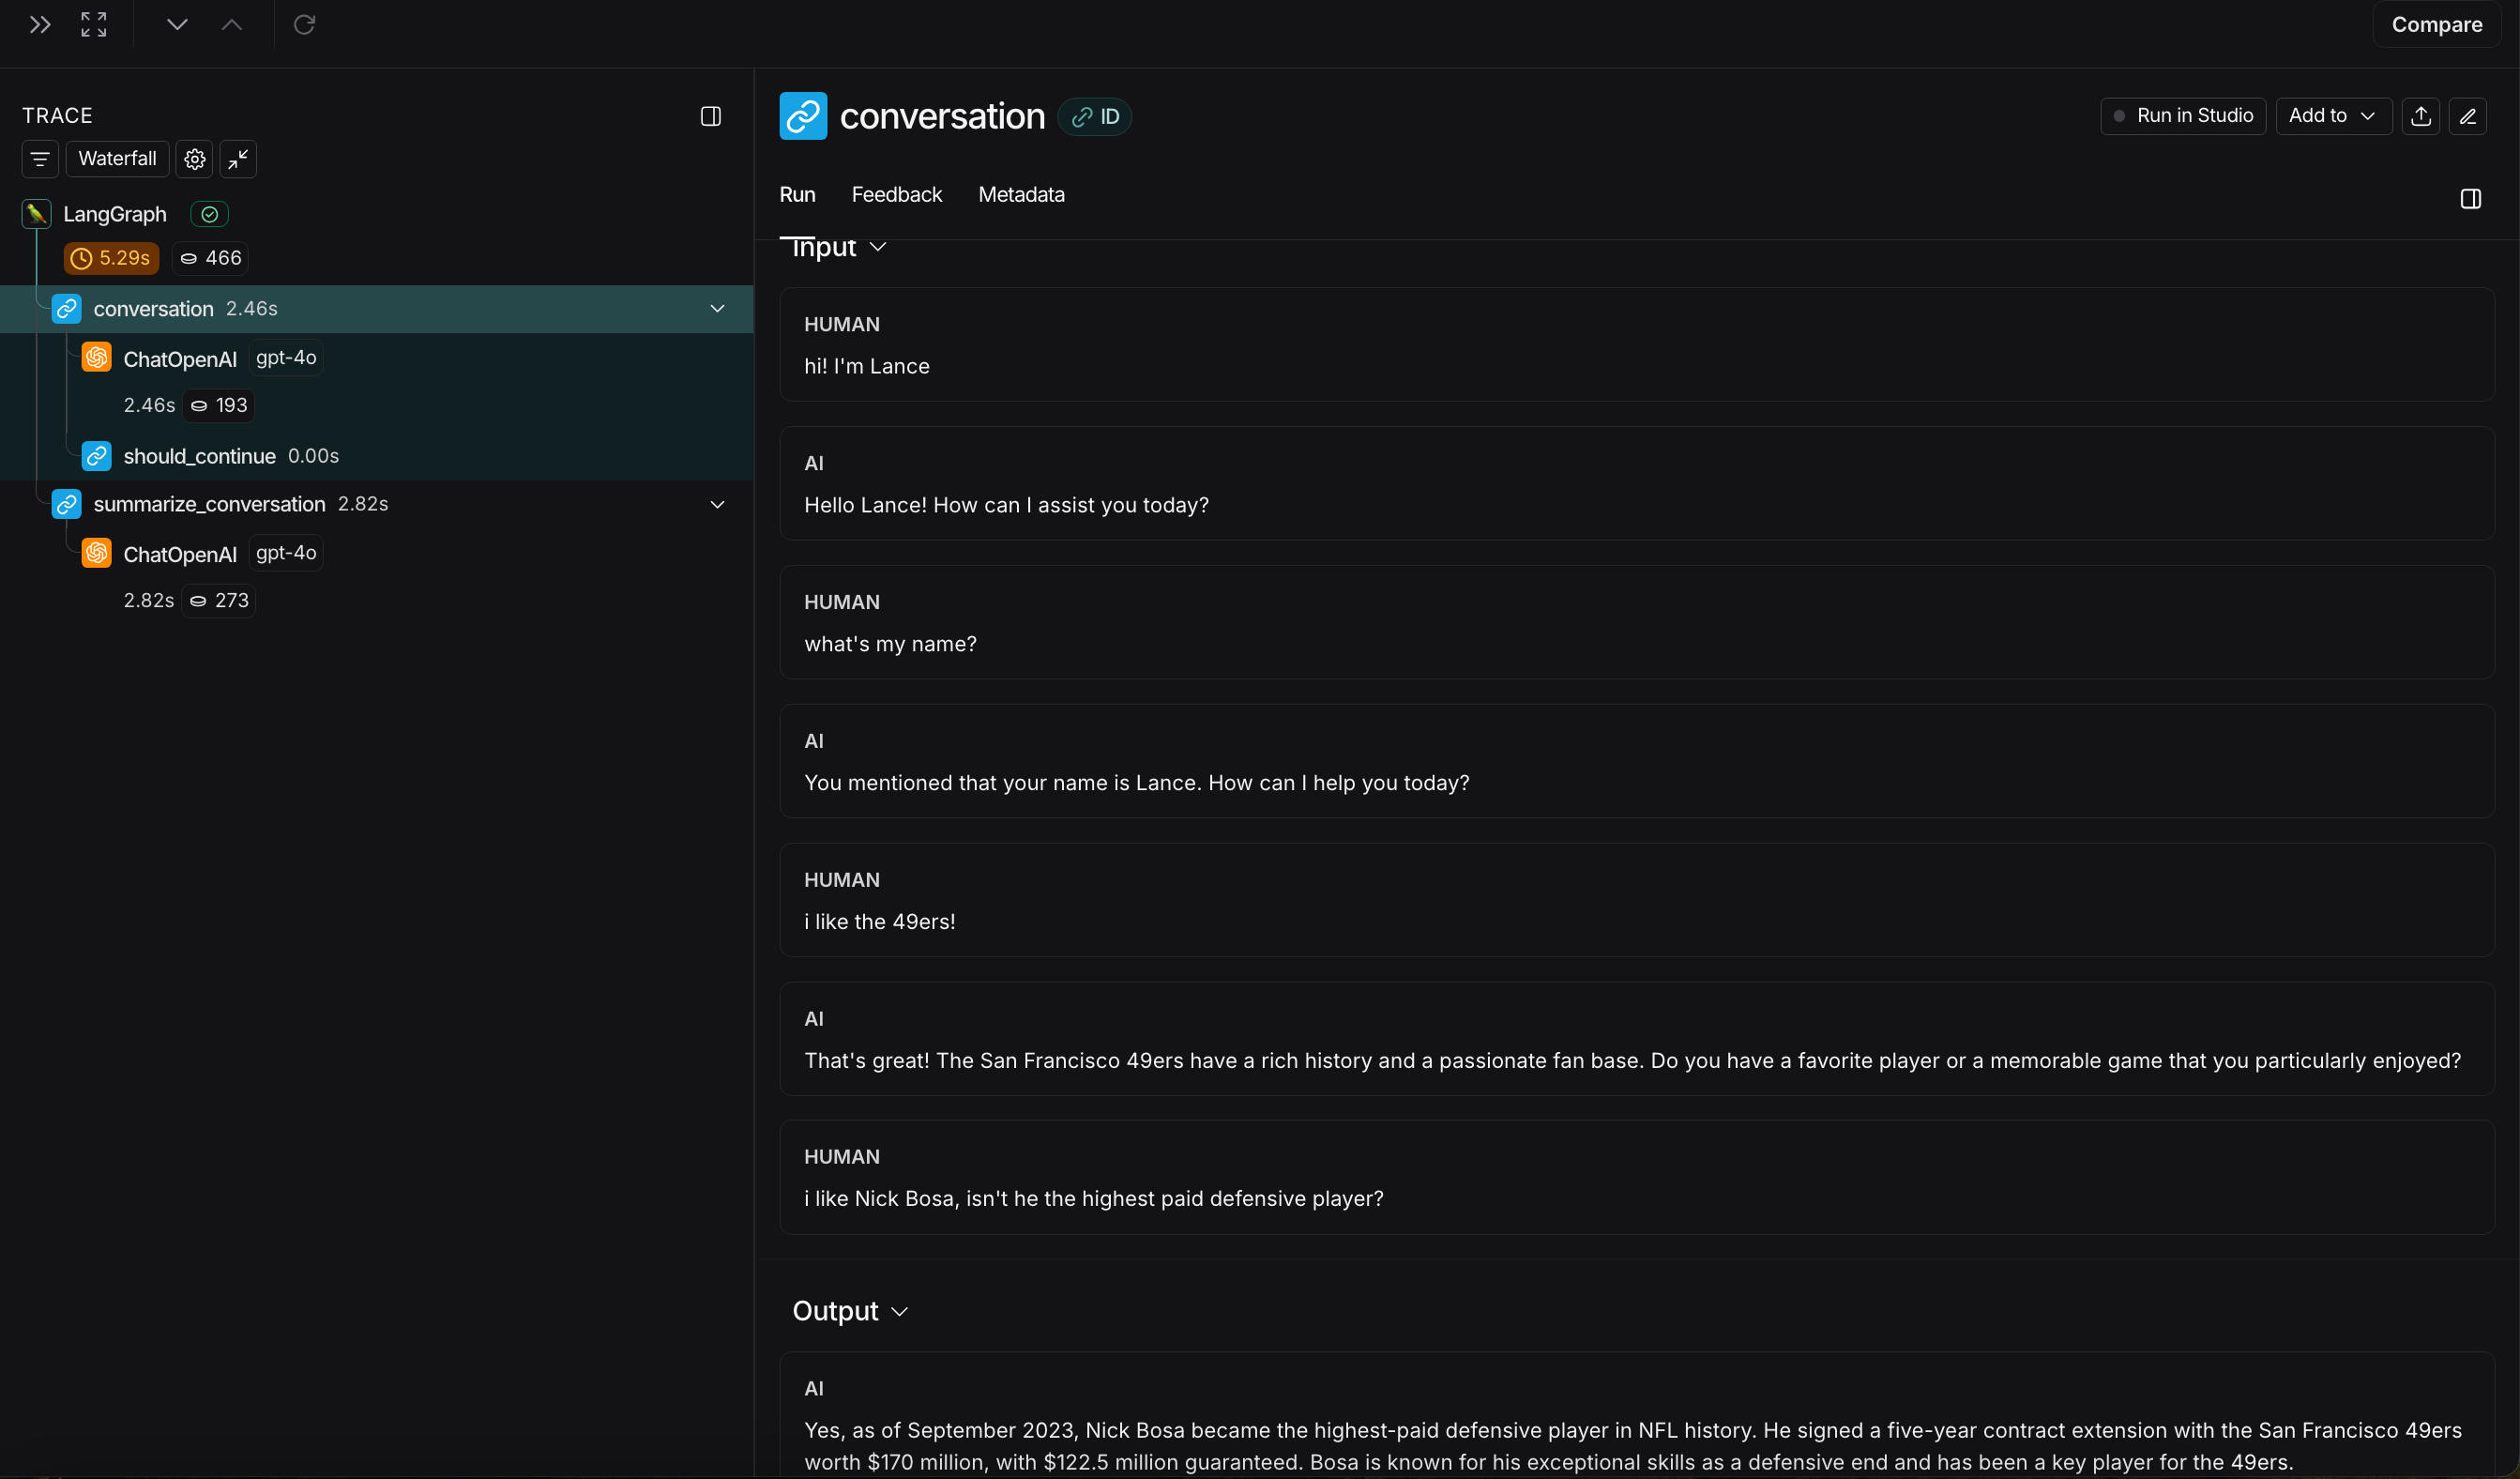
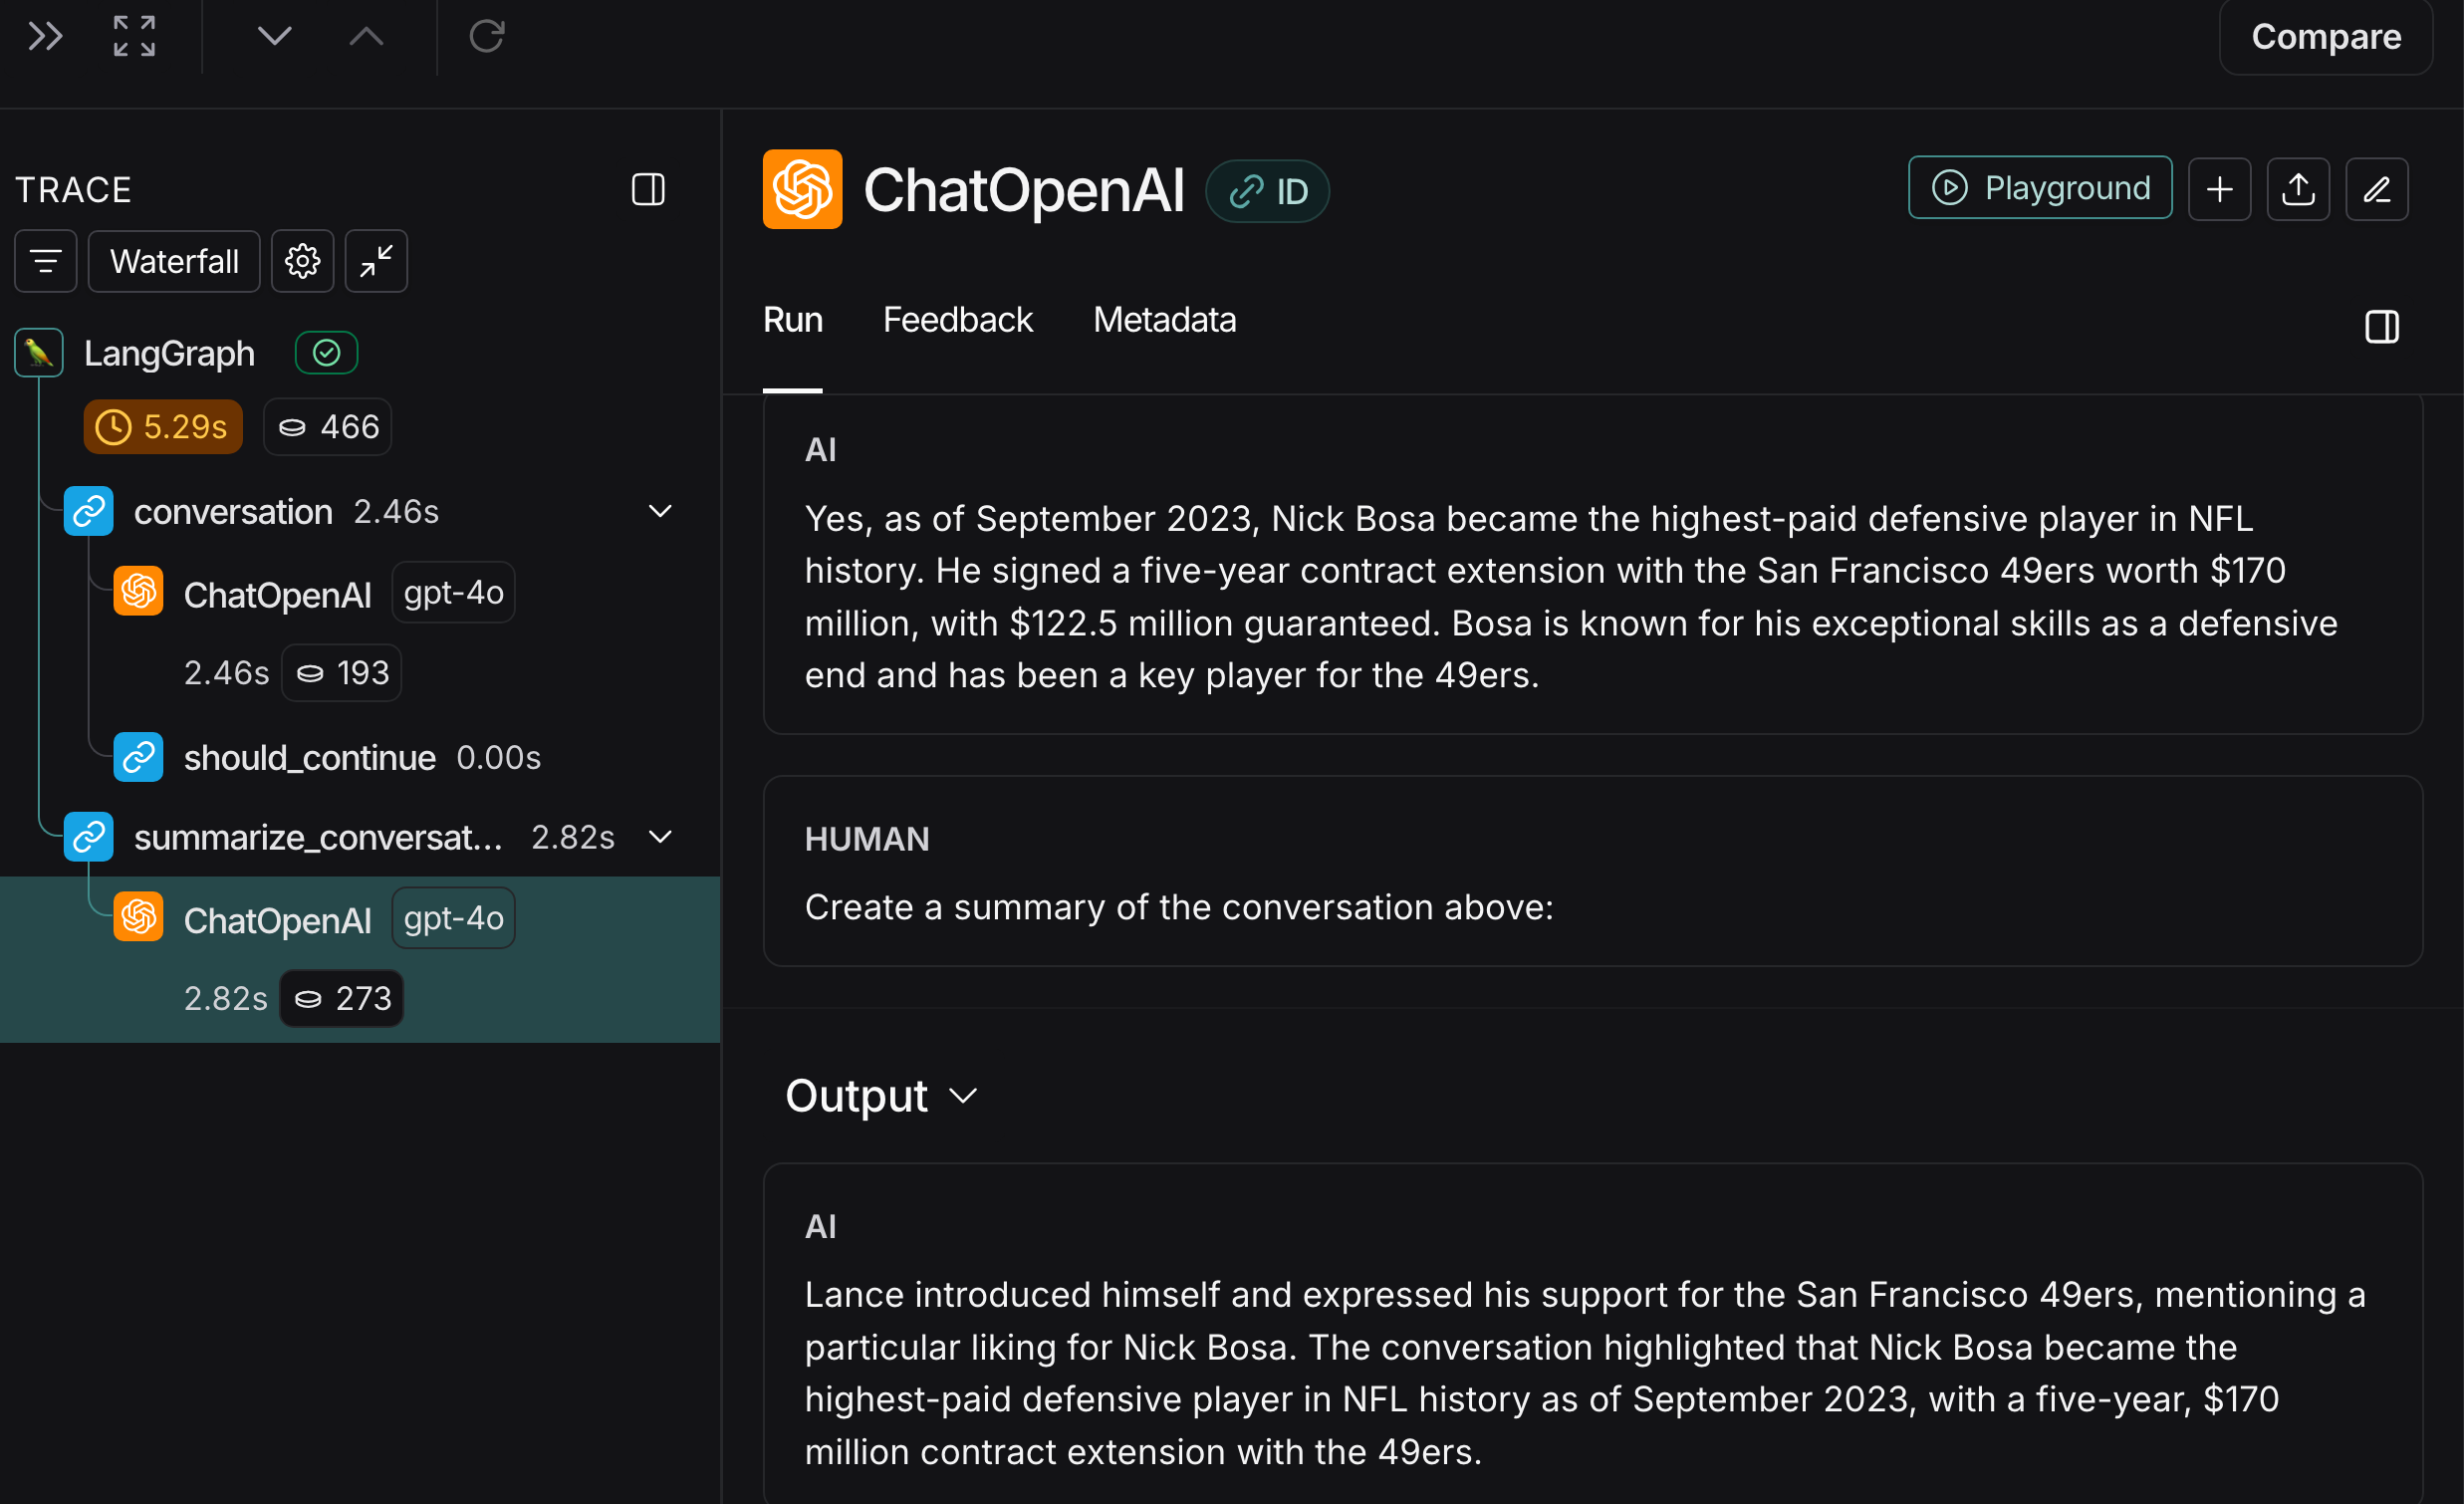

# SELF-EXERCISE:

In [14]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI

class State(MessagesState):
    summary: str

def call_model(state: State):
    summary = state.get("summary", "")

    if summary:
        system_message = f"Previous conversation summary: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"Current summary: {summary}\n\n"
            "Update this summary with the new messages above:"
        )
    else:
        summary_message = "Create a brief summary of this conversation:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State):
    messages = state["messages"]

    if len(messages) > 4:
        return "summarize_conversation"

    return END

In [15]:
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

In [16]:
config = {"configurable": {"thread_id": "weekend-trip-planning-1"}}

input_message = HumanMessage(content="Hey, I was thinking about going to the beach this weekend.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Do you know any good spots nearby?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Also, what kind of food should I try there?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Should I book a hotel or just go for the day?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()


================================== Ai Message ==================================

That sounds like a great idea! Going to the beach can be a relaxing and fun way to spend the weekend. Do you have a specific beach in mind, or are you still deciding? Also, it might be a good idea to check the weather forecast to ensure you have a pleasant experience. If you need any tips on what to bring or things to do at the beach, feel free to ask!
================================== Ai Message ==================================

I can certainly help with that! However, I'll need to know your general location or the area you're considering visiting to provide specific recommendations. If you can share that, I can suggest some popular beaches or hidden gems nearby.
================================== Ai Message ==================================

Beach destinations often have a variety of delicious food options, ranging from local specialties to classic beach snacks. Here are some popular choices you mig

In [17]:
summary = graph.get_state(config).values.get("summary", "")
print("Current Summary:", summary)

Current Summary: You mentioned considering a trip to the beach this weekend and asked for recommendations on good beach spots nearby. I requested your location to provide specific suggestions. Additionally, you inquired about food options to try at the beach, and I provided a list of popular choices, including seafood, tropical fruits, beach snacks, grilled foods, local cuisine, and refreshing drinks.


In [18]:
input_message = HumanMessage(content="Any tips on packing light for the trip?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Packing light can make your trip more convenient and stress-free. Here are some tips to help you pack efficiently for a beach trip:

1. **Plan Your Outfits**: Choose versatile clothing that can be mixed and matched. Opt for lightweight, breathable fabrics that are easy to wash and dry. Consider packing a couple of swimsuits, a cover-up, a pair of shorts, a few tops, and a sundress or casual outfit for the evening.

2. **Limit Shoes**: Bring only essential footwear. A pair of flip-flops or sandals for the beach and a comfortable pair of shoes for walking or dining out should suffice.

3. **Use Travel-Size Toiletries**: Pack travel-size toiletries to save space. Consider solid versions of products like shampoo, conditioner, and soap to avoid liquid restrictions and potential spills.

4. **Minimize Accessories**: Keep accessories to a minimum. A hat and sunglasses are essential for sun protection, but try to

In [19]:
summary = graph.get_state(config).values.get("summary", "")
print("Updated Summary:", summary)

Updated Summary: You mentioned considering a trip to the beach this weekend and asked for recommendations on good beach spots nearby. I requested your location to provide specific suggestions. Additionally, you inquired about food options to try at the beach, and I provided a list of popular choices, including seafood, tropical fruits, beach snacks, grilled foods, local cuisine, and refreshing drinks. You also asked whether to book a hotel or just go for the day, and I outlined factors to consider, such as distance, time, budget, experience, availability, and weather. Finally, you requested tips on packing light for the trip, and I suggested strategies like planning versatile outfits, limiting shoes and accessories, using travel-size toiletries, packing a lightweight towel, and leaving room for souvenirs.


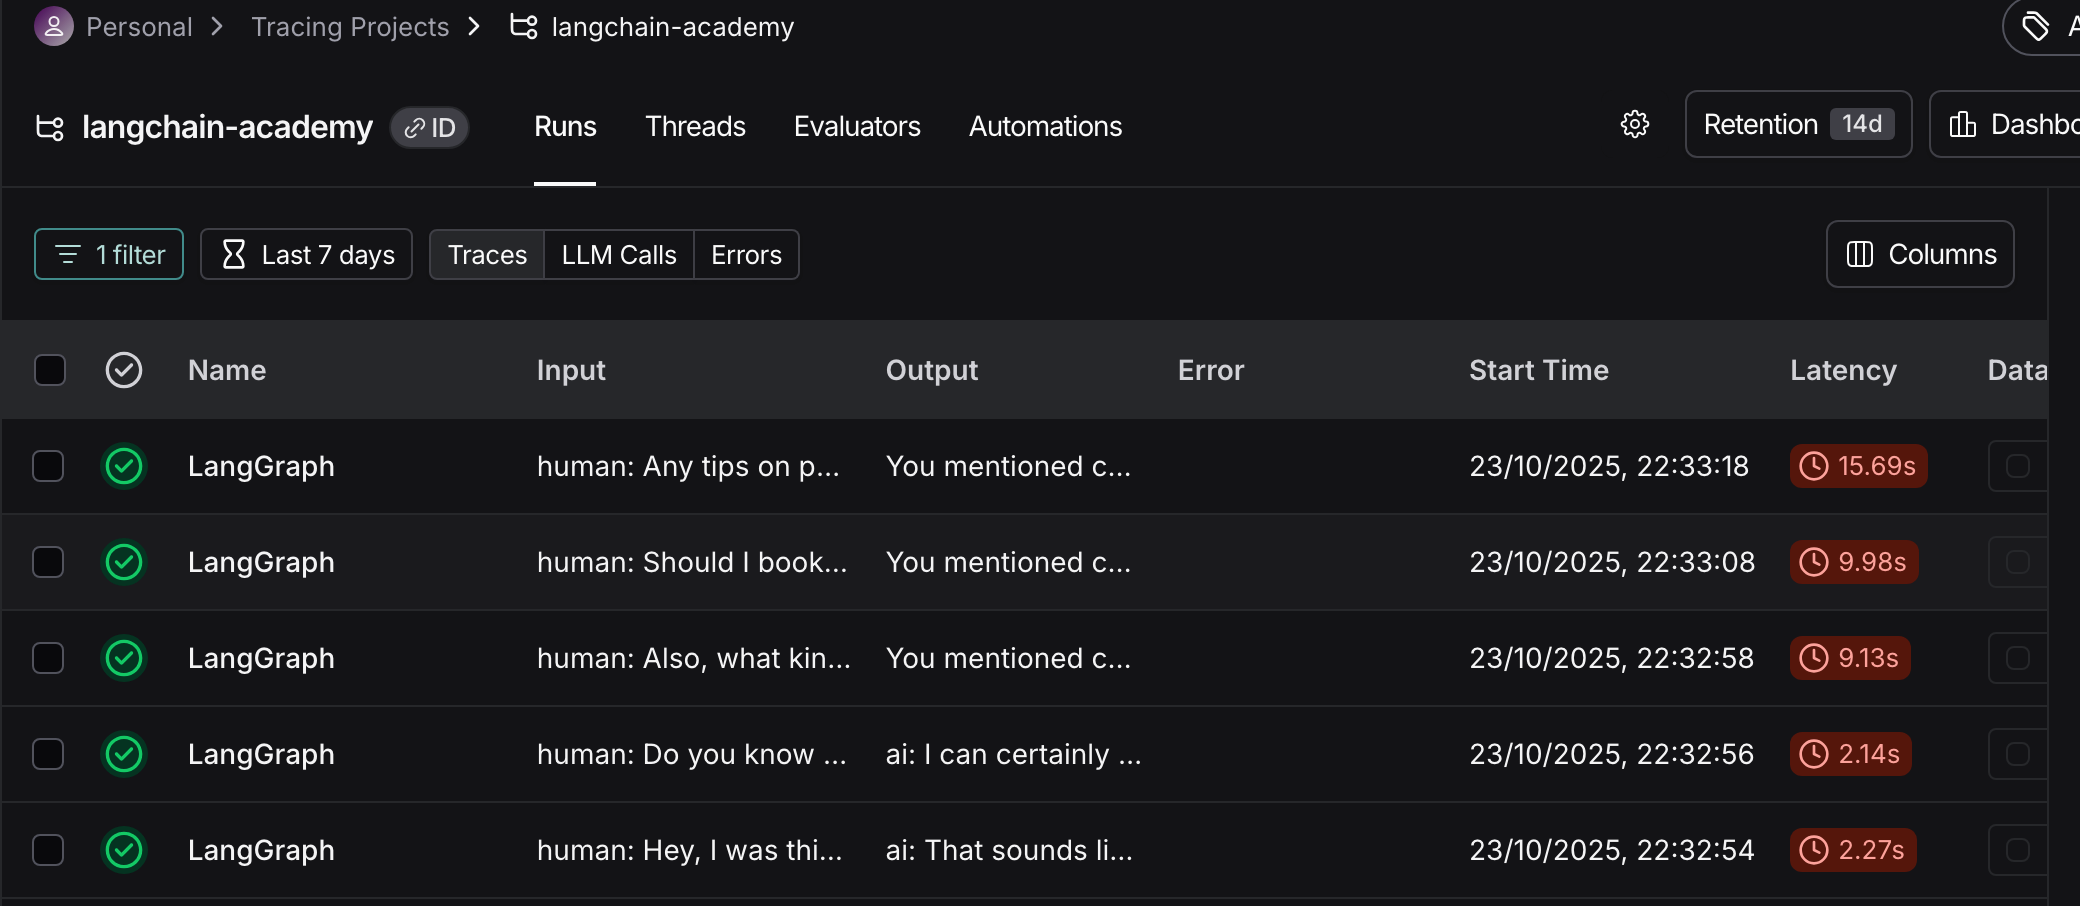
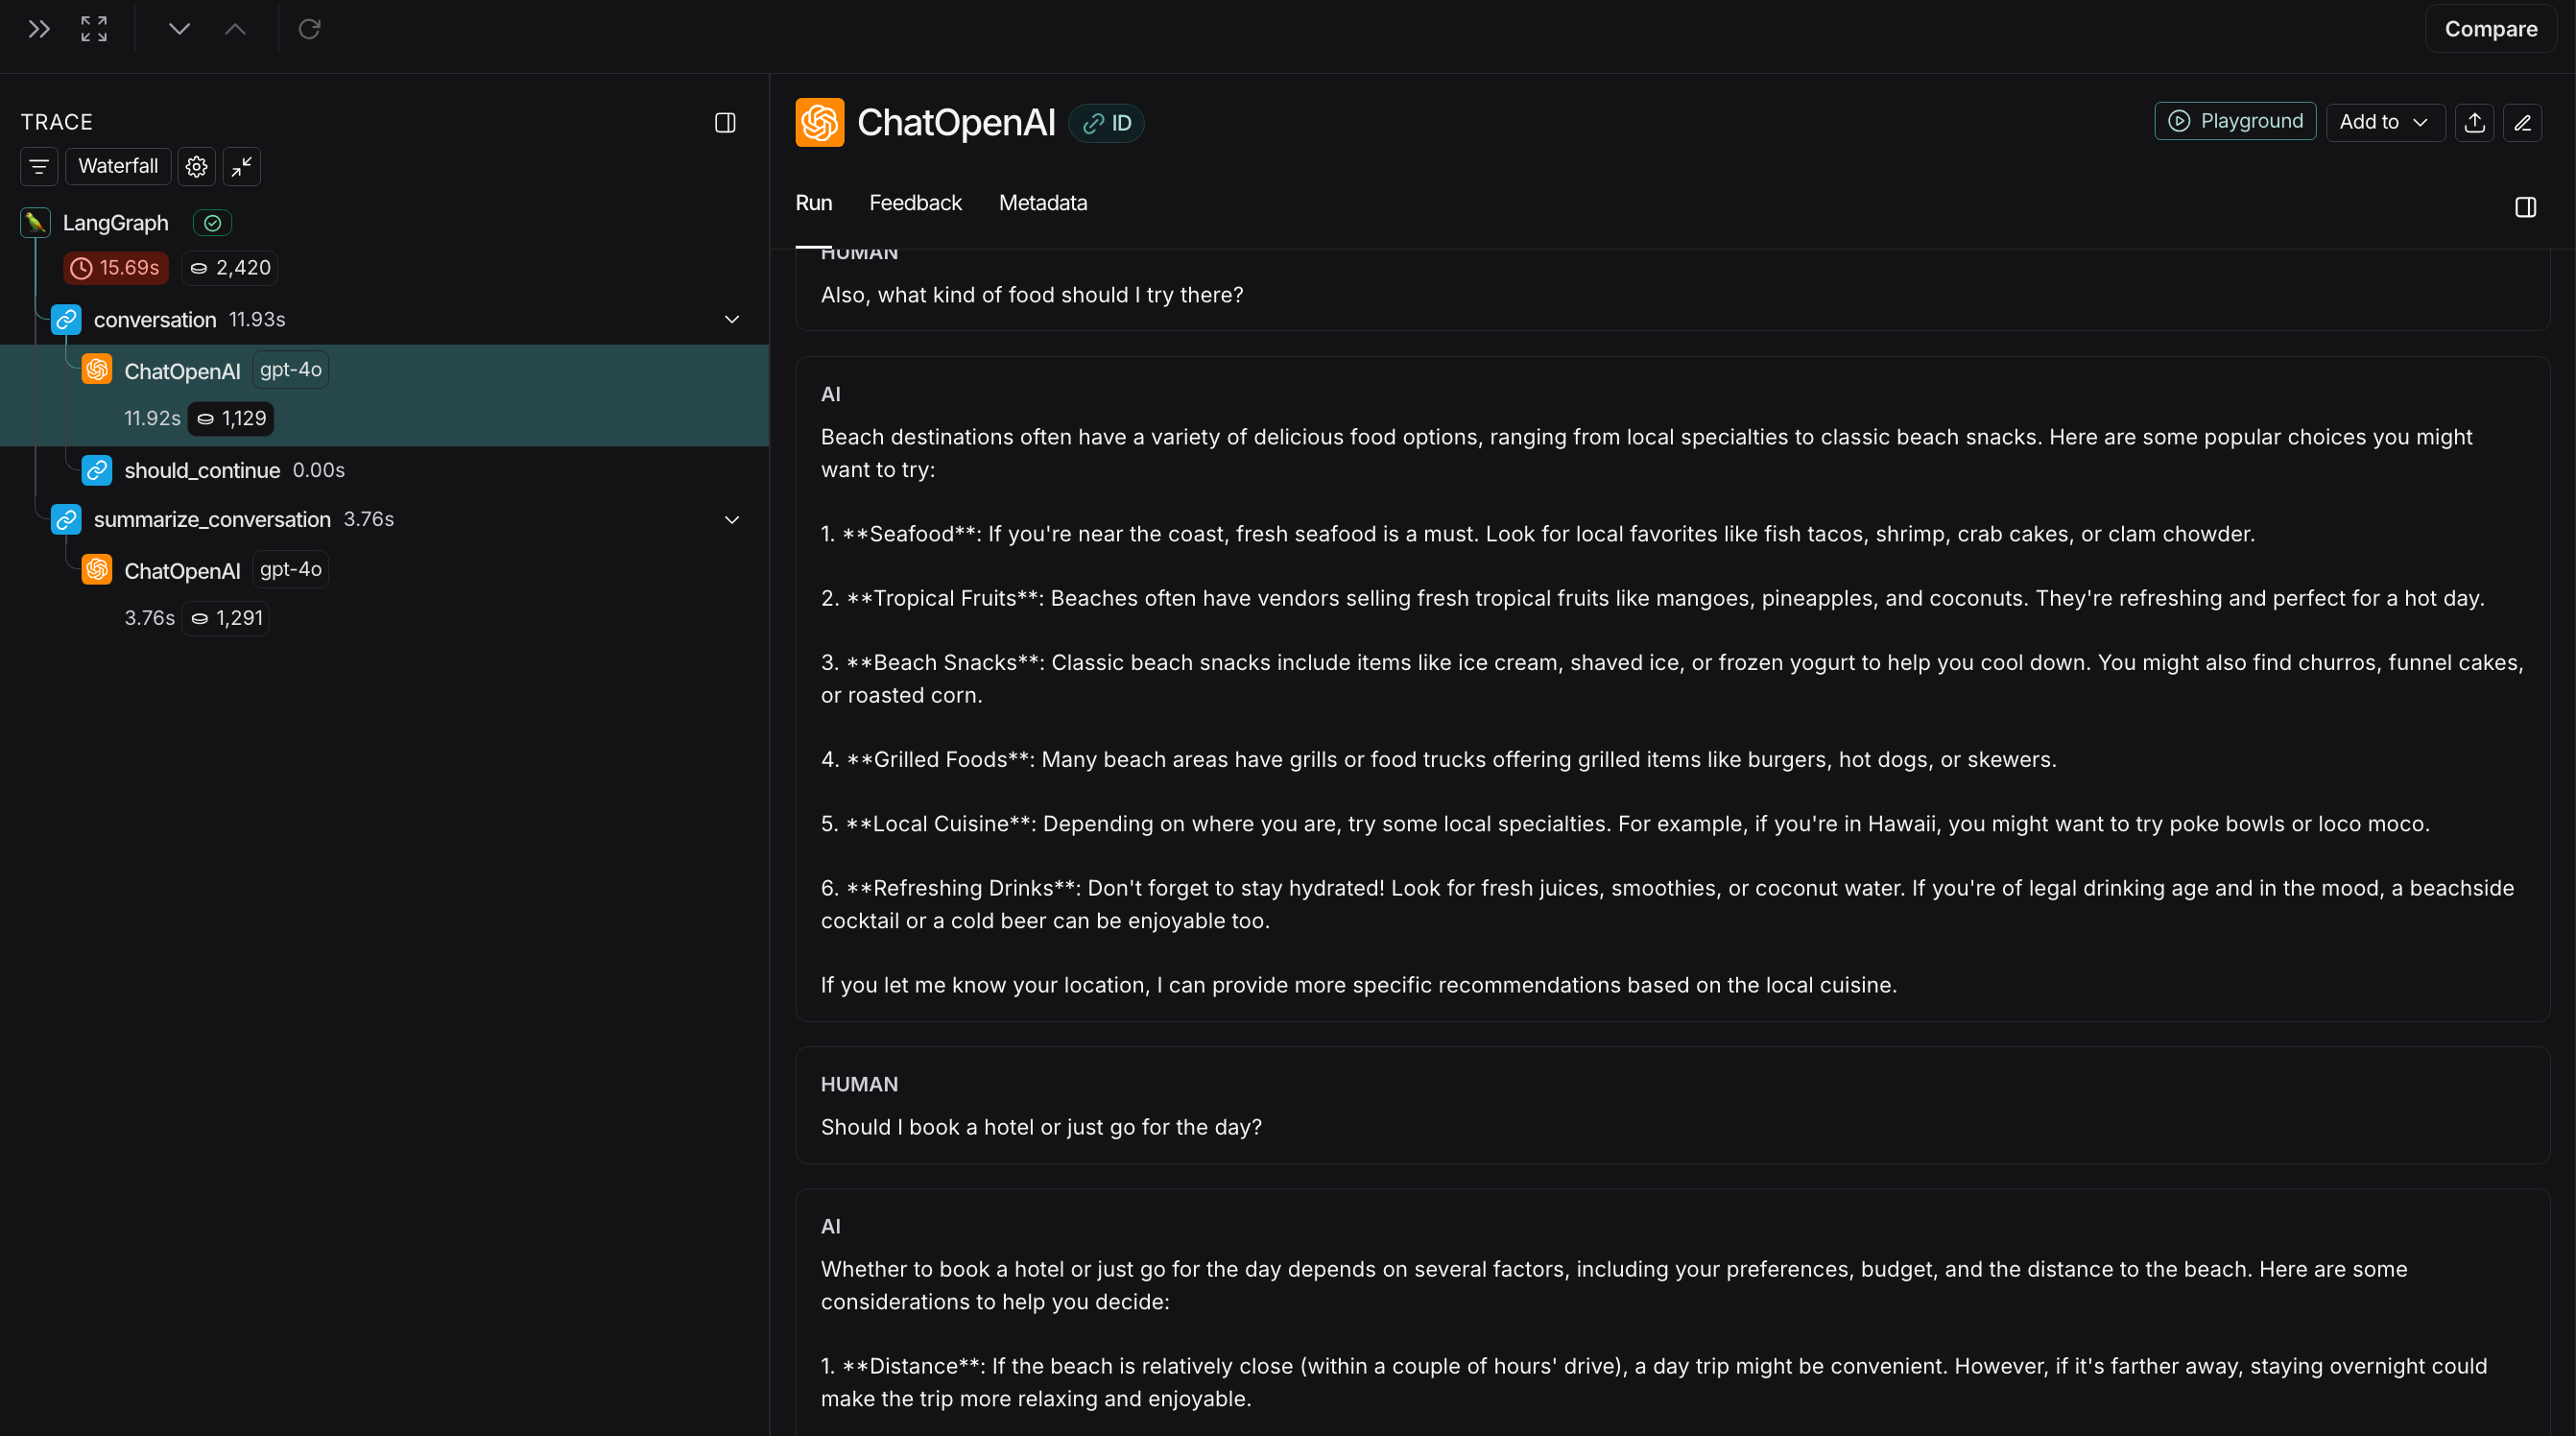
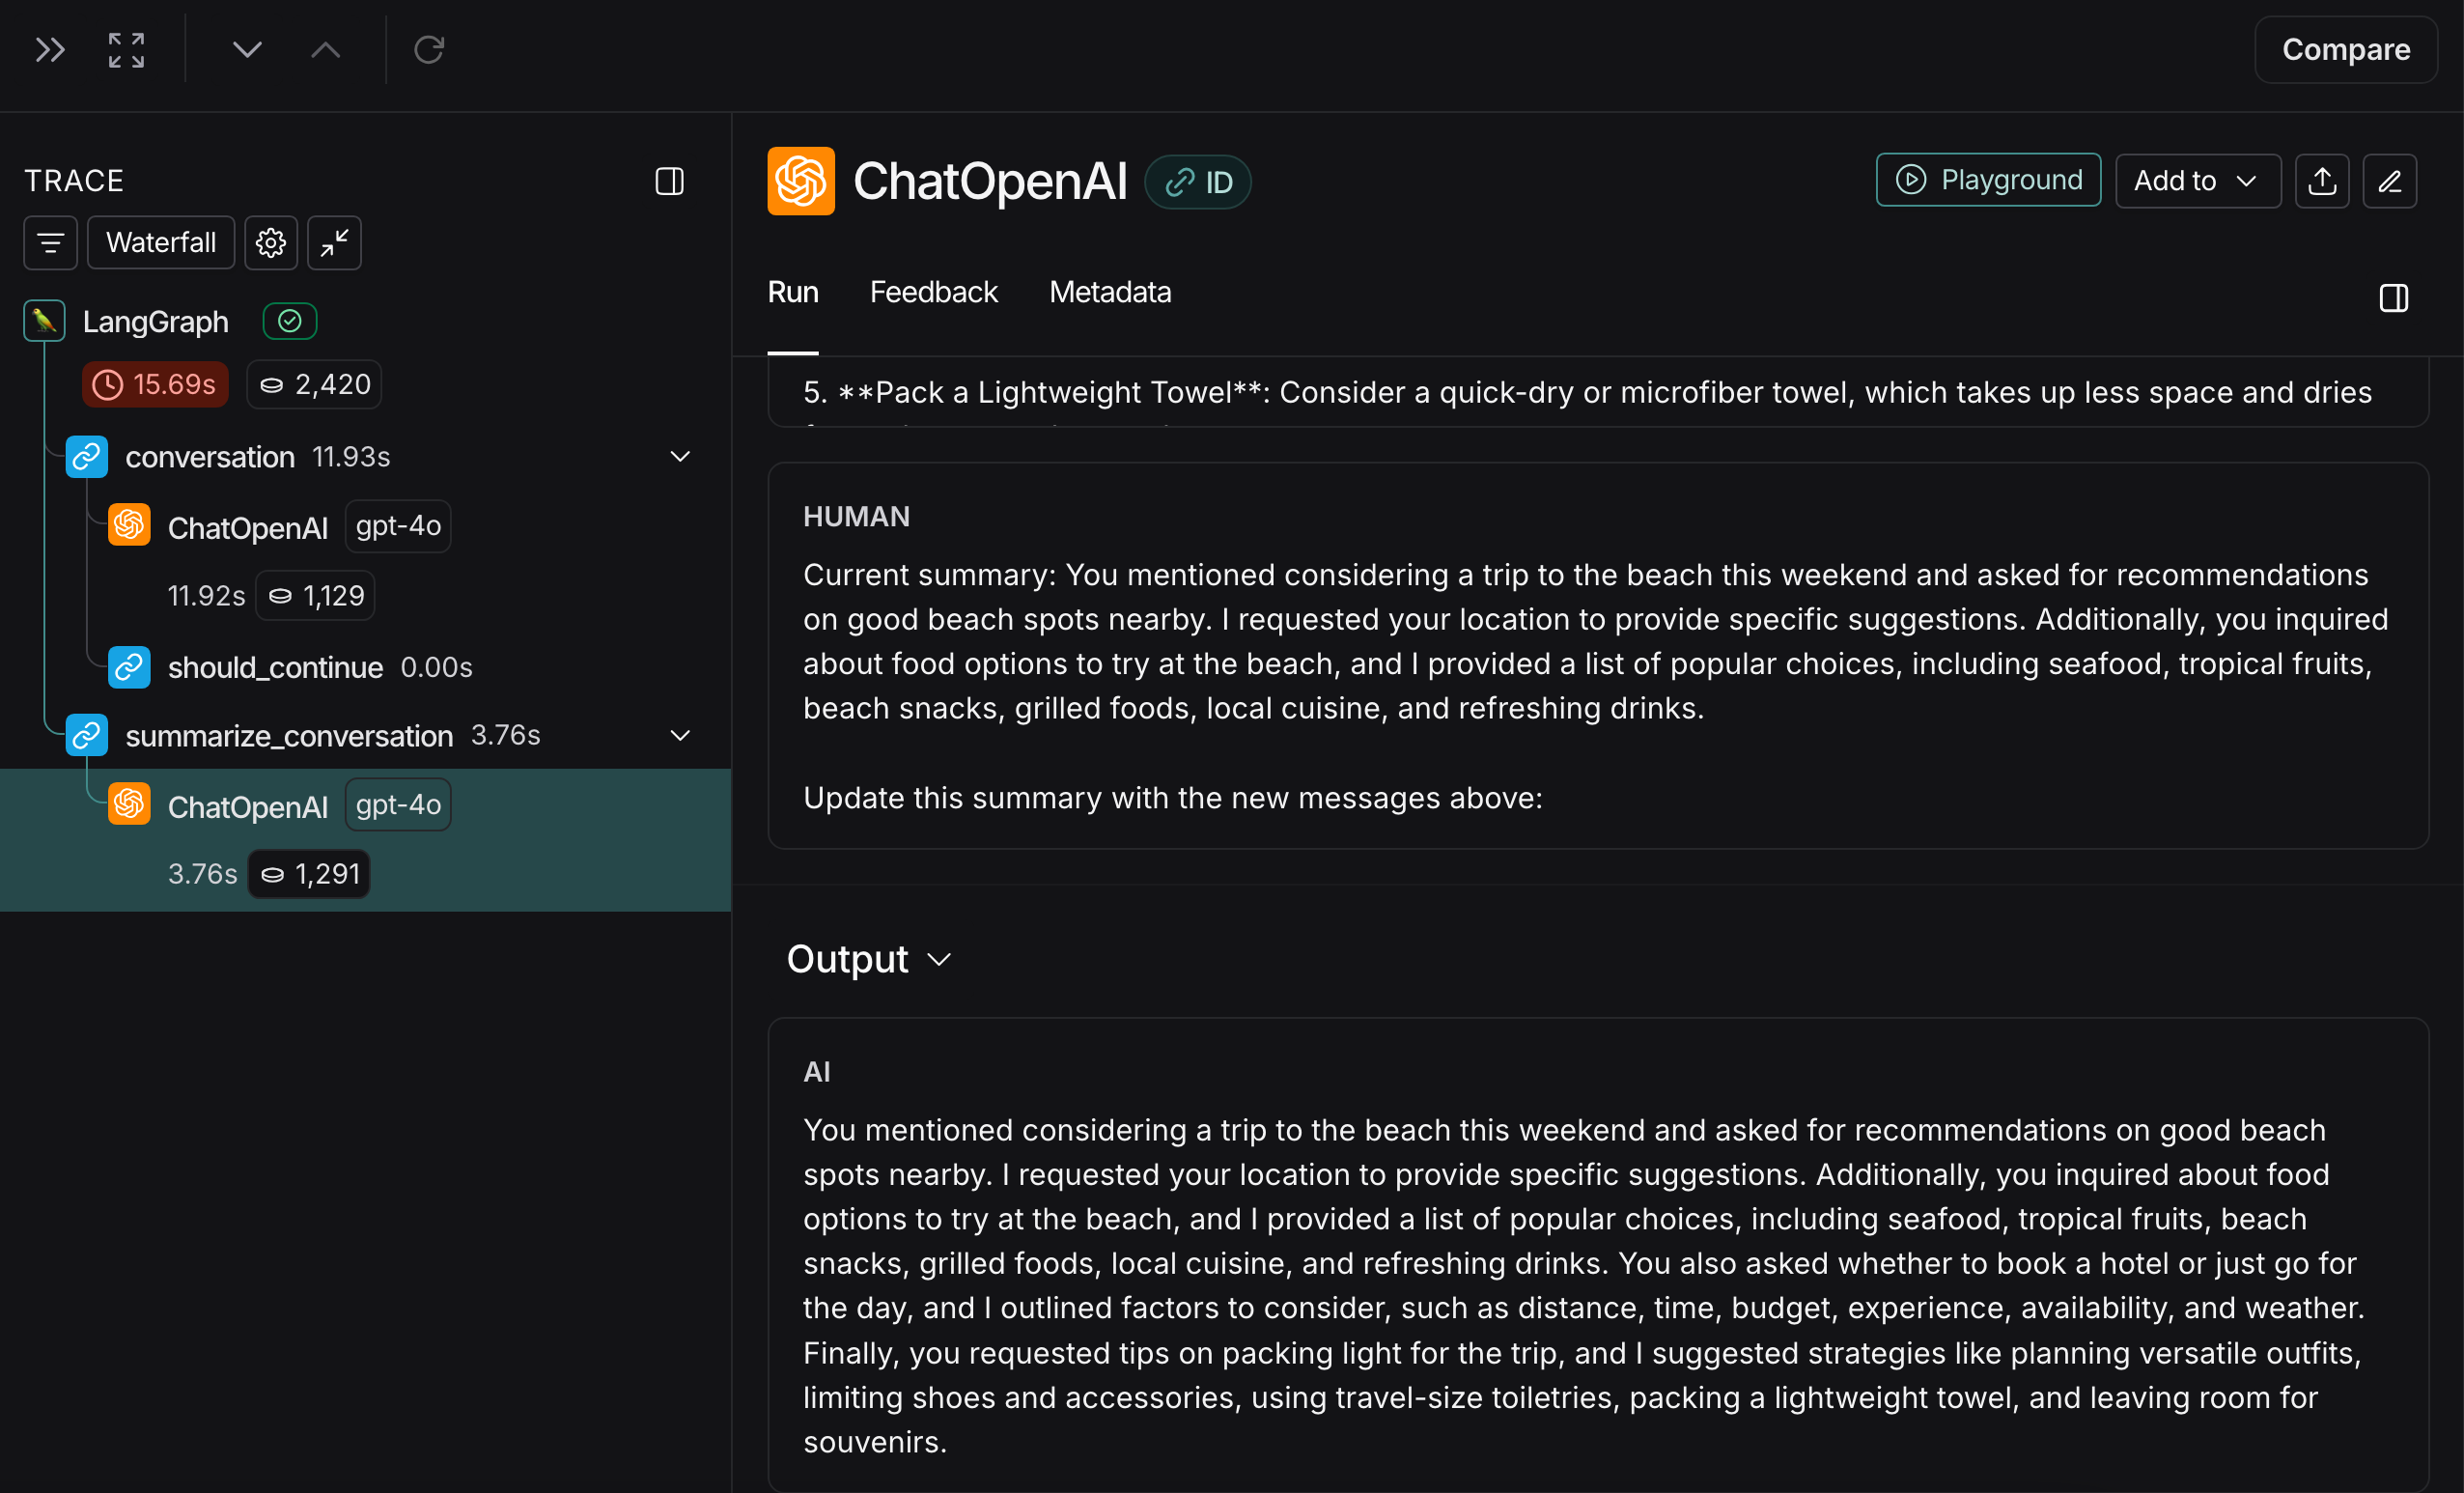